# 1. Data Preprocessing:

## Load dataset

In [4]:
import pandas as pd
df = pd.read_csv('diabetic_data.csv')
id_map = pd.read_csv('IDs_mapping.csv')
print(df.shape)
print(df.head())
print(id_map.head())

(101766, 50)
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No        

## Handle missing values and invalid entries

#### replacing '?' with NA

In [5]:
df = df.replace('?', pd.NA)
print(df.isnull().sum())

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

### Handling missing values by filling missing categorical columns with mode and numeric value with mean

In [6]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in df.select_dtypes(exclude='object').columns:
    df[col] = df[col].fillna(df[col].mean())

### Removing any duplicates

In [7]:
df = df.drop_duplicates()

#### stranderize text formats by converting all string columns to lowercase for consistency and ease of use

In [8]:
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

## Convert Multiclass to binary

#### The original column "readmitted" contains three possible values (<30,>30,NA). We want to make this into binary (1 for readmitted and 0 for not readmitted. For this, first we create new column "readmitted binary" and drop the old column.

In [9]:
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df = df.drop('readmitted', axis=1)

### Final Clean Dataset

In [10]:
print(df.info())
print(df['readmitted_binary'].value_counts())
df.to_csv('cleaned_diabetes_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# 2. Expolatory Data Analysis (EDA):

## Understand relationships between readmission and key features (e.g., age, number of medications, diagnosis codes)

#### first, import clean dataset

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("cleaned_diabetes_data.csv")
print(df.shape)
print(df.info())
print(df.describe())
print(df.head())

(101766, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int

### Overview of readmission classes


Overview of Readmission Distribution:
readmitted_binary
0    0.888401
1    0.111599
Name: proportion, dtype: float64


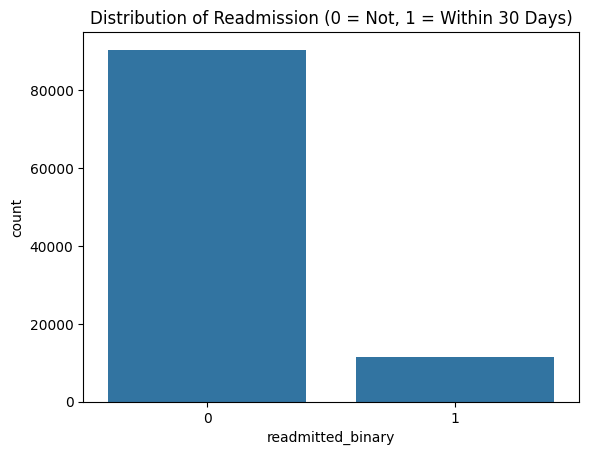

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
print("\nOverview of Readmission Distribution:")
print(df['readmitted_binary'].value_counts(normalize=True))
sns.countplot(x='readmitted_binary', data=df)
plt.title("Distribution of Readmission (0 = Not, 1 = Within 30 Days)")
plt.show()

### Relationship: Age vs Readmission

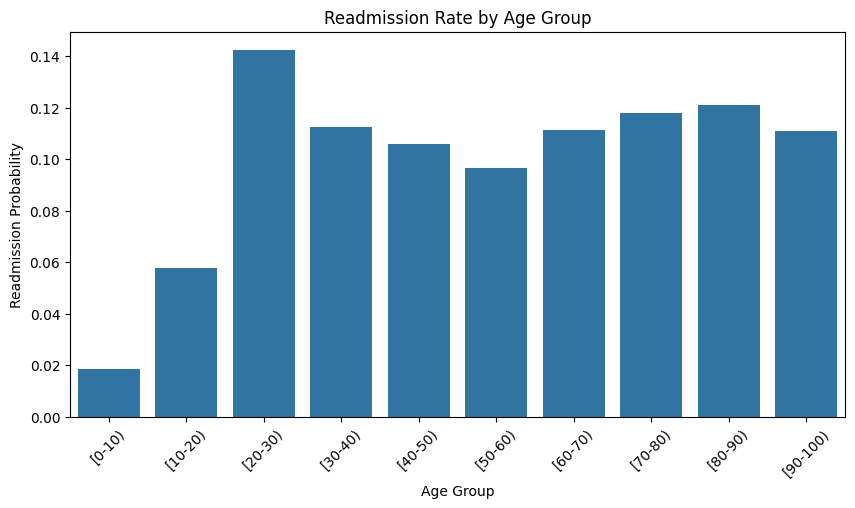


Average readmission rate by age group:
        age  readmitted_binary
2   [20-30)           0.142426
8   [80-90)           0.120835
7   [70-80)           0.117731
3   [30-40)           0.112318
6   [60-70)           0.111284
9  [90-100)           0.110992
4   [40-50)           0.106040
5   [50-60)           0.096662
1   [10-20)           0.057887
0    [0-10)           0.018634


In [13]:
df['age_numeric'] = df['age'].str.extract(r'(\d+)').astype(float)
plt.figure(figsize=(10,5))
sns.barplot(x='age', y='readmitted_binary', data=df, errorbar=None, order=sorted(df['age'].unique()))
plt.title("Readmission Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Readmission Probability")
plt.xticks(rotation=45)
plt.show()
age_readmit = df.groupby('age')['readmitted_binary'].mean().reset_index().sort_values(by='readmitted_binary', ascending=False)
print("\nAverage readmission rate by age group:")
print(age_readmit)

### Relationship: Number of Medications vs Readmission

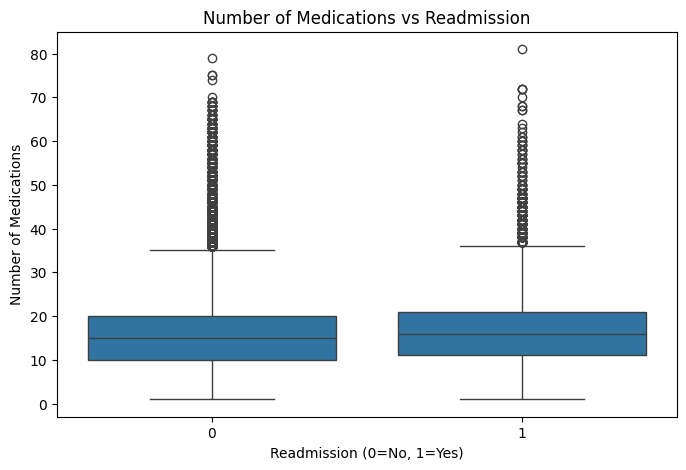


Average medications used by readmission status:
readmitted_binary
0    15.911137
1    16.903143
Name: num_medications, dtype: float64


In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='readmitted_binary', y='num_medications', data=df)
plt.title("Number of Medications vs Readmission")
plt.xlabel("Readmission (0=No, 1=Yes)")
plt.ylabel("Number of Medications")
plt.show()
print("\nAverage medications used by readmission status:")
print(df.groupby('readmitted_binary')['num_medications'].mean())

### Relationship: Number of Diagnoses vs Readmission

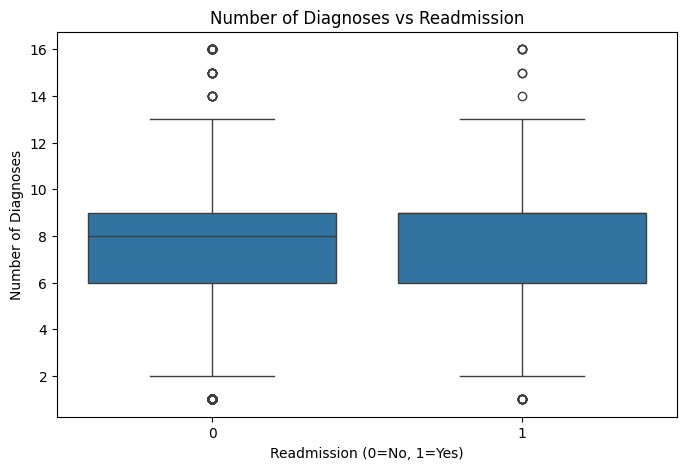


Average number of diagnoses by readmission status:
readmitted_binary
0    7.388667
1    7.692789
Name: number_diagnoses, dtype: float64


In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='readmitted_binary', y='number_diagnoses', data=df)
plt.title("Number of Diagnoses vs Readmission")
plt.xlabel("Readmission (0=No, 1=Yes)")
plt.ylabel("Number of Diagnoses")
plt.show()
print("\nAverage number of diagnoses by readmission status:")
print(df.groupby('readmitted_binary')['number_diagnoses'].mean())

#### Other Correlation between key numeric function

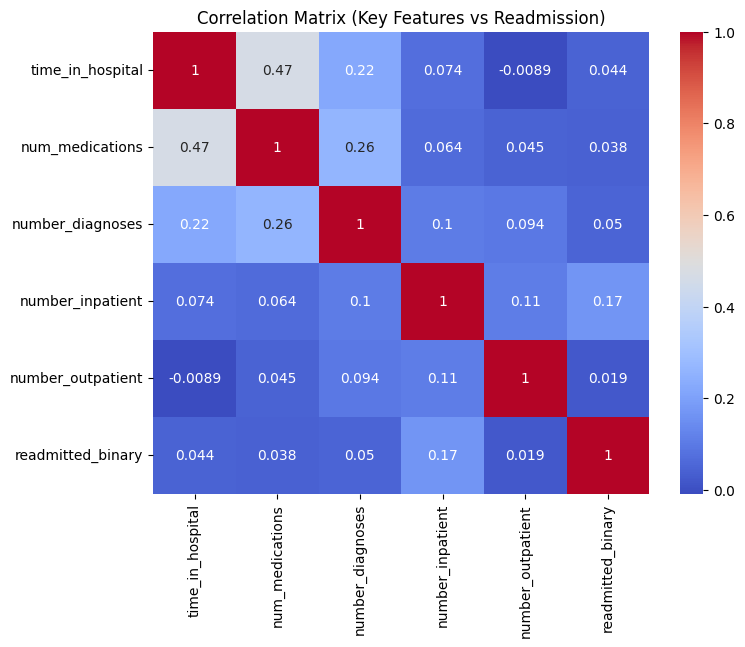

In [16]:
numeric_cols = ['time_in_hospital','num_medications','number_diagnoses',
                'number_inpatient','number_outpatient','readmitted_binary']
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Key Features vs Readmission)")
plt.show()

# 3. Feature Engineering:

#### Create useful features like:
#### Polypharmacy indicator (num_medications > X)
#### Chronic illness flags from diagnosis codes
#### Count of past procedures / admissions

#### But First we handle outliers, encode categorical values and do feature scaling.

##### Handling Outliers

In [17]:
import numpy as np
for col in ['num_medications', 'number_diagnoses', 'time_in_hospital']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] > upper, upper,
                       np.where(df[col] < lower, lower, df[col]))

##### Encode Categorical Variables (gender and race)

In [18]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['gender'] = df['gender'].map({'female': 1, 'male': 0}).fillna(0)

le = LabelEncoder()
df['race'] = le.fit_transform(df['race'])

##### Feature Scaling

In [19]:
scaler = StandardScaler()
df[['time_in_hospital', 'num_medications', 'number_diagnoses']] = scaler.fit_transform(
    df[['time_in_hospital', 'num_medications', 'number_diagnoses']]
)

### And now we create New Features (Creative Engineering)

#### Polypharmacy Indicator Flag ---> patients taking >10 meds

In [20]:
df['polypharmacy_flag'] = np.where(df['num_medications'] > 10, 1, 0)

##### Chronic Illness Flags → based on diagnosis codes

In [21]:
df['chronic_disease_flag'] = df['diag_1'].astype(str).str.startswith(('2', '3', '4', '5')).astype(int)

##### Total Admissions (sum of inpatient, outpatient, and emergency visits)

In [22]:
df['total_admissions'] = df['number_inpatient'] + df['number_outpatient'] + df['number_emergency']

##### Length of Stay Indicator ---> longer stays may indicate severe conditions

In [23]:
df['long_stay_flag'] = np.where(df['time_in_hospital'] > df['time_in_hospital'].median(), 1, 0)

##### Multi-diagnosis Indicator → complex patients

In [24]:
df['multi_diagnosis_flag'] = np.where(df['number_diagnoses'] > 7, 1, 0)

### Feature Selection (we will keep relevant ones)

In [25]:
selected_features = [
    'race', 'gender', 'time_in_hospital', 'num_medications', 'number_diagnoses',
    'polypharmacy_flag', 'chronic_disease_flag', 'total_admissions',
    'long_stay_flag', 'multi_diagnosis_flag', 'readmitted_binary'
]

df = df[selected_features]

#### Feature Correlation heatmap

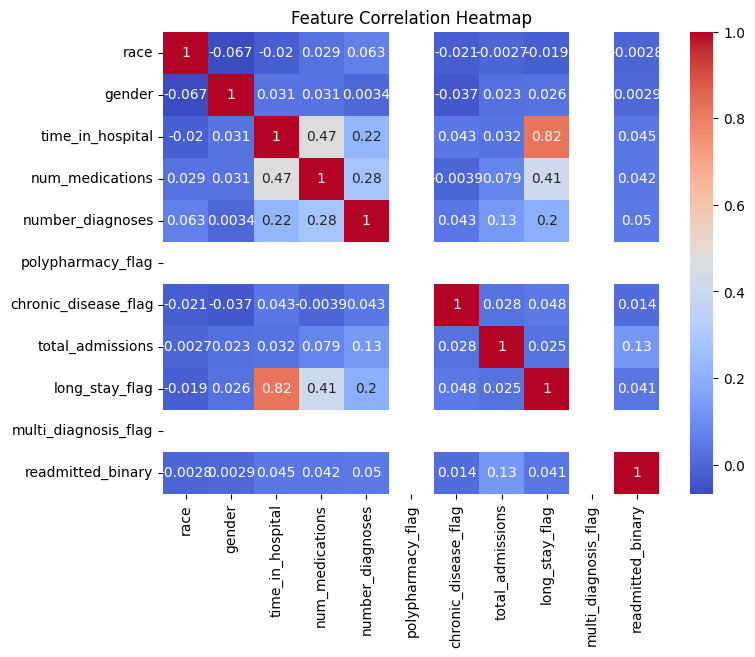

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

#### Final engineered feature dataset

In [27]:
df.to_csv("engineered_features.csv", index=False)
print("✅ Feature Engineering complete! File saved as 'engineered_features.csv'")
print(df.head())

✅ Feature Engineering complete! File saved as 'engineered_features.csv'
   race  gender  time_in_hospital  num_medications  number_diagnoses  \
0     2     1.0         -1.163010        -2.002068         -3.076064   
1     2     1.0         -0.471487         0.296283          0.819400   
2     0     1.0         -0.817248        -0.379703         -0.738786   
3     2     0.0         -0.817248         0.025889         -0.219390   
4     2     0.0         -1.163010        -1.055688         -1.258181   

   polypharmacy_flag  chronic_disease_flag  total_admissions  long_stay_flag  \
0                  0                     1                 0               0   
1                  0                     1                 0               0   
2                  0                     0                 3               0   
3                  0                     0                 0               0   
4                  0                     0                 0               0   

   multi_diagn

# 4. Modeling:

### Load engineered dataset

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv("engineered_features.csv")

# Separate features and target
X = df.drop('readmitted_binary', axis=1)
y = df['readmitted_binary']

sample_df = df.sample(frac=0.2, random_state=42)  # 20% for faster run
X_sample = sample_df.drop('readmitted_binary', axis=1)
y_sample = sample_df['readmitted_binary']

### Train and test

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Now, scale numerical features

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Define Models (Logistic regression, Random forest, XGBoost)

In [32]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', C=1, class_weight='balanced', probability=True, random_state=42)
}

### Stratified Cross-Validation (to optimize recall / F1)

In [33]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_results = {}
for name, model in models.items():
    print(f"Running {name}...")
    f1 = cross_val_score(model, X_sample, y_sample, cv=skf, scoring='f1', n_jobs=-1).mean()
    recall = cross_val_score(model, X_sample, y_sample, cv=skf, scoring='recall', n_jobs=-1).mean()
    cv_results[name] = {"F1 Score": f1, "Recall": recall}
    cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results (Fast Version):")
print(cv_df.sort_values(by="F1 Score", ascending=False))


Running Logistic Regression...
Running Random Forest...
Running Gradient Boosting...
Running Support Vector Machine...

Cross-Validation Results (Fast Version):
                        F1 Score    Recall
Support Vector Machine  0.239805  0.615319
Logistic Regression     0.237952  0.514217
Random Forest           0.209122  0.316851
Gradient Boosting       0.006009  0.003064


### Finally, Train on full train set

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

# Use smaller subset for faster runtime if dataset is large
X_small = X_train_scaled[:5000]
y_small = y_train[:5000]

# --- Train two lightweight models ---
log_reg = LogisticRegression(max_iter=300, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf
}

results = {}

for name, model in models.items():
    model.fit(X_small, y_small)
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    results[name] = f1
    print(f"\n=== {name} ===")
    print("F1 Score:", round(f1, 3))
    print(classification_report(y_test, y_pred))

# --- Choose best model ---
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest Model based on F1 Score: {best_model_name}")

# --- Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test_scaled)), annot=True, fmt='d', cmap='Blues')
plt.title(f'{best_model_name} - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- ROC Curve ---
y_pred_proba = best_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{best_model_name} ROC Curve')
plt.legend()
plt.show()


In [ ]:
best_model_name = cv_df["F1 Score"].idxmax()
print(f"\n Best Model based on CV: {best_model_name}")

best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)


 Best Model based on CV: Support Vector Machine


### Evaluate on Test Set

In [2]:
y_pred = best_model.predict(X_test_scaled)
print("\n🔹 Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ({best_model_name})')
plt.show()

NameError: name 'best_model' is not defined

## Feature Importance / Influence

In [ ]:
if best_model_name == "Random Forest" or best_model_name == "Gradient Boosting":
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=importances[:10], y=importances.index[:10])
    plt.title(f"Top 10 Important Features ({best_model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

elif best_model_name == "Logistic Regression":
    importance = pd.Series(np.abs(best_model.coef_[0]), index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=importance[:10], y=importance.index[:10])
    plt.title("Top 10 Features (Logistic Regression)")
    plt.xlabel("Coefficient Magnitude")
    plt.ylabel("Feature")
    plt.show()

else:
    print("\nSVM does not provide direct feature importances, but you can use SHAP or permutation importance for interpretation.")

### Key Insights

In [ ]:
print("\n Key Insights:")
print(f"- The model with best F1 score is: {best_model_name}")
print(f"- Mean Recall across folds: {cv_df.loc[best_model_name, 'Recall']:.3f}")
print("- Higher recall ensures fewer missed high-risk patients (false negatives).")